# Assignment 0

In [51]:
import pandas as pd
import numpy as np
from numpy import linalg as LNG
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import umap

np.random.seed(42)

# Supress deprecation warnings
import warnings
warnings.filterwarnings('error', category=DeprecationWarning) 

In [52]:
# Training inputs (image as vector)
X_train = pd.read_csv("data/train_in.csv").to_numpy()

# Training outputs (number that each vector represents)
Y_train = pd.read_csv("data/train_out.csv").to_numpy()

X_test = pd.read_csv("data/test_in.csv").to_numpy()
Y_test = pd.read_csv("data/test_out.csv").to_numpy()

## Calculating the center for each cloud c_d

In [53]:
def get_digit_cloud(X, Y, digit):
    # Finding all the indexes from Y_train_out related to digit
    d_indices = np.where(Y == digit)[0]

    # an array of all images related to the current d
    return X[d_indices]

In [54]:
# Stores calculated centers
# Label corresponds to index, eg. Center_0 = clouds[0]
cloud_centers = []

for d in range(10):
    cloud_d = get_digit_cloud(X_train, Y_train, d)

    # Calculating the mean/center of each cloud
    center_d = np.mean(cloud_d, axis=0)

    # add each mean vector to clouds
    cloud_centers.append(center_d)

## Calculating center distances for each digit/label

In [67]:
distances_matrix = np.full((10,10), np.NaN)

for row_index in range(0,10):
    for column_index in range(0,10):
        if column_index == row_index or not np.isnan(distances_matrix[column_index, row_index]):
            continue

        c1 = cloud_centers[row_index]
        c2 = cloud_centers[column_index]
        
        distances_matrix[row_index, column_index] = LNG.norm(c1 - c2)

In [57]:
pd.DataFrame(distances_matrix)

,0,1,2,3,4,5,6,7,8,9
0,NaN,14.449608,9.334556,9.143734,10.769844,7.519296,8.163019,11.864555,9.907902,11.488875
1,NaN,NaN,10.125323,11.733233,10.173786,11.118800,10.597933,10.743154,10.086777,9.932094
2,NaN,NaN,NaN,8.178285,7.932541,7.906796,7.317952,8.872531,7.077516,8.887748
3,NaN,NaN,NaN,NaN,9.087608,6.118750,9.292426,8.922401,7.020425,8.354350
4,NaN,NaN,NaN,NaN,NaN,8.001517,8.765997,7.583012,7.380909,6.010408
5,NaN,NaN,NaN,NaN,NaN,NaN,6.688629,9.211954,6.967386,8.258538
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.868157,8.570208,10.419744
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.467785,5.426474
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.401166
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Classificating new vectors

In [58]:
def classify(new_vector):
    distances_to_clouds = [LNG.norm(new_vector-center) for center in cloud_centers]

    # Returns the label for the first closest cloud
    return np.argmin(distances_to_clouds)

## Running model on test set to check accuracy

In [59]:
correct = 0

for x_test, y_test in zip(X_test, Y_test):
    # feed input to model
    y_predict = classify(x_test)

    if y_predict == y_test:
        correct+=1

accuracy = correct / X_test.shape[0] * 100

print(f"Accuracy: {accuracy}%")

Accuracy: 80.38038038038037%


## Dimensionality Reduction

In [60]:
distinct_colors = ['#FF0000', '#0000FF', '#00FF00', '#FFFF00', '#FFA500', '#800080', '#00FFFF', '#FF00FF', '#A52A2A', '#008080']

### PCA

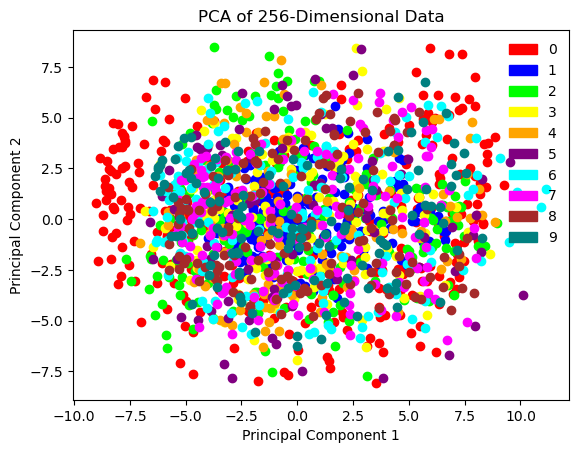

In [61]:
# Initiaze PCA
n_components = 2 # number of dimensions to be plotted

pca = PCA(n_components=n_components, random_state=42)

# patches for legend visualization
patches = []

for d in range(0,10):
    cloud_d = get_digit_cloud(X_train, Y_train, d)

    # Fit PCA model to vectors
    cloud_pca = pca.fit_transform(cloud_d)

    X = cloud_pca[:, 0]
    Y = cloud_pca[:, 1]

    patches.append(mpatches.Patch(color=distinct_colors[d],label=d))

    plt.scatter(X, Y, c = distinct_colors[d])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of 256-Dimensional Data')

plt.legend(handles=patches, loc='best',frameon=False)
plt.show()
    

### U-MAP

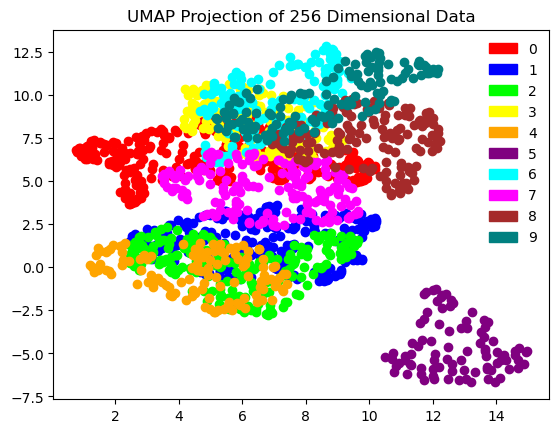

In [62]:
# initialize UMAP
umap_reducer = umap.UMAP(random_state=42)

# patches for legend visualization
patches = []

for d in range(0,10):
    cloud_d = get_digit_cloud(X_train, Y_train, d)

    # Fit U-MAP model to vectors
    cloud_umap = umap_reducer.fit_transform(cloud_d)

    X = cloud_umap[:, 0]
    Y = cloud_umap[:, 1]

    patches.append(mpatches.Patch(color=distinct_colors[d],label=d))

    plt.scatter(X, Y, c=distinct_colors[d])
    plt.title('UMAP Projection of 256 Dimensional Data')

plt.legend(handles=patches, loc='best', frameon=False)
plt.show()

In [63]:
def compare_clouds(d1, d2):
    cloud_0 = get_digit_cloud(X_train, Y_train, d1)
    cloud_1 = get_digit_cloud(X_train,Y_train, d2)

    cloud_0_umap = umap_reducer.fit_transform(cloud_0)
    cloud_1_umap = umap_reducer.fit_transform(cloud_1)

    plt.scatter(cloud_0_umap[:,0], cloud_0_umap[:,1], c="red")
    plt.scatter(cloud_1_umap[:,0], cloud_1_umap[:,1], c="blue")
    plt.legend(handles=[mpatches.Patch(color="red",label=d1), mpatches.Patch(color="blue",label=d2)])
    plt.show()